In [22]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
import glob
import os
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input 
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

img_width = 128
img_height = 128

spec_width = 128
spec_height = 128

num_imgs = 30

2.9.0


In [23]:
data_path = "C:/Users/Scrip0/Desktop/Internships/Magician AI/MagicianDatasetApp/Data"
img_ext = ["jpg","png", "jpeg"];
sound_ext = ["wav"];
ext = img_ext + sound_ext


def load_img(path):
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR), (img_width, img_height))
    img = np.array(img) / 256.0
    return img

fr_model = keras.models.load_model('Face_recognition.h5')

def load_audio(path):
    audio = Audio.from_file(path).trim(0.05,2.05)
    
    spectrogram = Spectrogram.from_audio(audio)
    
    image = spectrogram.to_image(shape=(spec_width, spec_height),invert=False)

    return np.array(image) / 256

def prep_imgs(imgs):
    length = len(imgs)
    if (length > num_imgs):
        n = length - num_imgs
        i = (int)(length / (n + 1))
        for l in range(1, n + 1):
            imgs.pop(length - i * l)
    elif (len(imgs) < num_imgs):
        n =  num_imgs - length
        i = (int)(length / (n + 1))
        for l in range(1, n + 1):
            imgs.insert(length - i * l, imgs[length - i * l - 1])
    return imgs

In [24]:
imgs = []
images = []
labels = []
sounds = []

for path in glob.glob(f'{data_path + "/True"}/*/'):
    for files in (files for files in (glob.glob(path + '/*.%s' % e) for e in ext) if files != []):
        if (os.path.splitext(files[0])[1].split(".")[1] in sound_ext):
            sounds.append(load_audio(files[0]))
        else:
            for file in files:
                imgs.append(load_img(file))
            images.append(fr_model.predict(np.array(prep_imgs(imgs)), verbose = 0))
            labels.append(1.0)
            imgs = []
        
for path in glob.glob(f'{data_path + "/False"}/*/'):
    for files in (files for files in (glob.glob(path + '/*.%s' % e) for e in ext) if files != []):
        if (os.path.splitext(files[0])[1].split(".")[1] in sound_ext):
             sounds.append(load_audio(files[0]))
        else:
            for file in files:
                imgs.append(load_img(file))
            images.append(fr_model.predict(np.array(prep_imgs(imgs)), verbose = 0))
            labels.append(0.0)
            imgs = []

print("Imgs len: ", len(imgs))
print("Labels len: ", len(labels))
print("Images len: ", len(images))
print("Sounds len: ", len(sounds))

print("Images arr len: ", len(images[0]))

Imgs len:  0
Labels len:  1
Images len:  1
Sounds len:  1
Images arr len:  30


IndexError: list index out of range

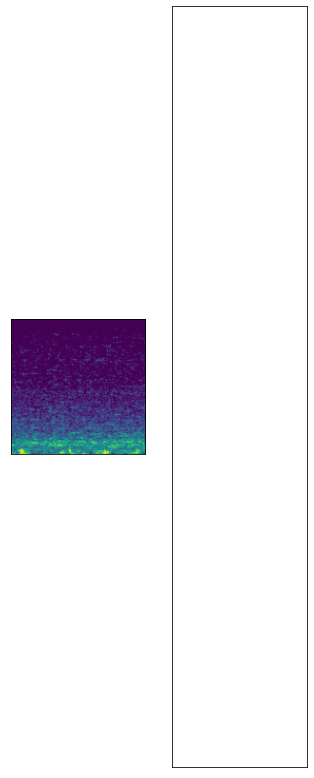

In [16]:
plt.figure(figsize=(14,14))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sounds[i].astype('float32'))
plt.show()

In [ ]:
images = np.array(images)
images = images.reshape(images.shape[0], 30)
labels = np.array(labels)
sounds = np.array(sounds)
images, sounds, labels = shuffle(images, sounds, labels)

In [ ]:
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(images, sounds, labels, train_size=0.8, random_state=1) 

In [ ]:
print(x1_train.shape) # Results of Face_recognition_ML
print(x2_train.shape) # Sounds
print(y_train.shape)  # Labels

In [ ]:
# Results of Face_recognition_ML
input_1 = tf.keras.layers.Input(shape=(30))

dense_1_1 = tf.keras.layers.Dense(8, activation="relu")(input_1)

dense_1_2 = tf.keras.layers.Dense(4, activation="relu")(dense_1_1)

# Sounds
input_2 = tf.keras.layers.Input(shape=(spec_width, spec_height, 1))

conv2d_2_1 = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(input_2)

conv2d_2_2 = tf.keras.layers.Conv2D(16, kernel_size=3, activation="relu")(conv2d_2_1)

conv2d_2_3 = tf.keras.layers.Conv2D(8, kernel_size=3, activation="relu")(conv2d_2_1) 

flatten_2 = tf.keras.layers.Flatten()(conv2d_2_3)

# Concatenate
concat = tf.keras.layers.Concatenate()([dense_1_2, flatten_2])

output = tf.keras.layers.Dense(1, activation="sigmoid")(concat)

model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 126, 126, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                            

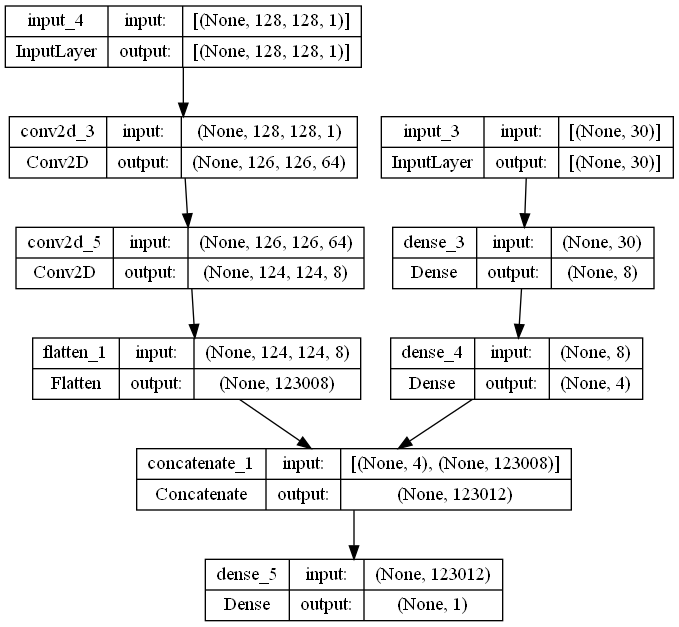

In [59]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [60]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss="MeanSquaredError")

In [61]:
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
history = model.fit([x1_train, x2_train], y_train, validation_data=([x1_test, x2_test], y_test), batch_size=5, epochs=100, callbacks=[early_stop])

Epoch 1/100
3/3 [==============================] - 1s 181ms/step - loss: 0.1887 - val_loss: 0.0147
Epoch 2/100
3/3 [==============================] - 0s 56ms/step - loss: 0.1339 - val_loss: 2.9128e-04
Epoch 3/100
3/3 [==============================] - 0s 32ms/step - loss: 0.1480 - val_loss: 6.9466e-05
Epoch 4/100
3/3 [==============================] - 0s 34ms/step - loss: 0.1500 - val_loss: 6.5945e-05
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.1488 - val_loss: 2.7888e-04
Epoch 6/100
3/3 [==============================] - 0s 27ms/step - loss: 0.1449 - val_loss: 0.0022
Epoch 7/100
3/3 [==============================] - 0s 27ms/step - loss: 0.1287 - val_loss: 0.0185
Epoch 8/100
3/3 [==============================] - 0s 25ms/step - loss: 0.1121 - val_loss: 0.0542
Epoch 9/100
3/3 [==============================] - 0s 30ms/step - loss: 0.1037 - val_loss: 0.0378


In [62]:
model.save('Magician.h5')

In [66]:
path_to_folder = 'C:/Users/Scrip0/Desktop/Internships/Magician AI/MagicianDatasetApp/Data/True/25_07_19_47_39_seven/'
model = keras.models.load_model('Magician.h5')
fr_model = keras.models.load_model('Face_recognition.h5')

list_of_files = sorted(filter(lambda x: os.path.isfile(os.path.join(path_to_folder, x)), os.listdir(path_to_folder)))
imgs = []
for file in list_of_files:
    if (os.path.splitext(file)[1].split(".")[1] in sound_ext):
        sound = load_audio(path_to_folder + file)
    else: 
        imgs.append(load_img(path_to_folder + file))

imgs = fr_model.predict(np.array(imgs), verbose = 0)

In [67]:
imgs = imgs.reshape(1, 30)
sound = sound.reshape(1, spec_width, spec_height)
print(sound.shape)
print(imgs.shape)

(1, 128, 128)
(1, 30)


In [68]:
model.predict([imgs, sound])[0][0]

1/1 [==============================] - 0s 91ms/step


0.98353475